In [1]:
!pip install mxnet-cu100mkl

     |████████████████████████████████| 576.6MB 29kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


# __AC GAN (Conditional Image Synthesis With Auxiliary Classifier GANs) - MXNet (From Scratch)__

In [1]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt

ctx = mx.gpu()

In [2]:
def transform(data):
    return data.reshape((784)).astype('float32')/255.0

train_mnist = gluon.data.vision.MNIST(train = True).transform_first(transform)

In [3]:
image, label = train_mnist[1]
print(image.shape)
print(label)

(784,)
0


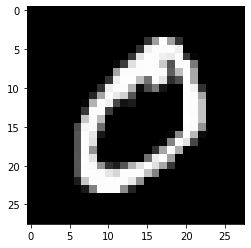

In [4]:
plt.imshow(image.reshape((28, 28)).asnumpy(), 'gray')
plt.show()

## __Creating data loader for training and testing__

In [5]:
batch_size = 64
training_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = True)

## __Building the GAN model__

In acgan the discriminator makes two predictions, first one to properly classify the data feeded to it and second one to consider it as true or false.

And likewise the generator in cgan, the generator in acgan also generates data using noise combined with desired output category.

Lets consider __x__ as true data, __y__ as __x__'s labels, __x_hat__ as false data generated by generator when feeded with noise __z__ combined with true labels or classes of true data __x__, __y_true__ as prediction of discriminator for true data for being true, __y_true_classes__ as predicted classes for same, and __y_false__ as prediction of discriminator for false data for being false, __y_false_classes__ as predicted classes for generated data.

So discriminator takes data > predicts its class(using softmax function) and its nature of being true or false(using sigmoid function). Hence it's output layer out will have k + 1 number of neurons where k is number of classes. The softmax is applied to first k neurons and sigmoid to last neuron. This is know as soft-sigmoid activation function.

Discriminator is trained to consider true data as true by minimizing __"-log(y_true)"__ and to consider false data as false data by minimizing __"-log(1 - y_false)"__.... which is basically exactly like vanilla gan

And here is the difference, the discriminator is also trained to correctly predict the classes of __both true data and false data__, by minimizing __"(-y*log(y_true_classes)) + (-y*log(y_false_classes))"__.

And the generator is not only trained to fool the discriminator by minimizing __"-log(y_false)"__ but also to generated data that can be correctly clasified by the classifier by minimizing __"-y*log(y_false_classes)"__.

In [11]:

# ===================== Discriminator Parameters ===========================
dw1 = nd.random.normal(0, 1, (784, 128), ctx = ctx) * 0.001
db1 = nd.random.normal(0, 1, 128, ctx = ctx) * 0.001

# for predicting whether the data is true or false
dw2_source = nd.random.normal(0, 1, (128, 1), ctx = ctx) * 0.001
db2_source = nd.random.normal(0, 1, 1, ctx = ctx) * 0.001

# for predicting class(out of 10) of the data(for both true and false)
dw2_aux = nd.random.normal(0, 1, (128, 10), ctx = ctx) * 0.001
db2_aux = nd.random.normal(0, 1, 10, ctx = ctx) * 0.001
# ==========================================================================

# ======================= Generator Parameters =============================
# after concatenation the input layer would be of shape (-1, 110) that is why we have 110 as input neurons
gw1 = nd.random.normal(0, 1, (110, 128), ctx = ctx) * 0.001

gb1 = nd.random.normal(0, 1, 128, ctx = ctx) * 0.001

gw2 = nd.random.normal(0, 1, (128, 784), ctx = ctx) * 0.001
gb2 = nd.random.normal(0, 1, 784, ctx = ctx) * 0.001
# ==========================================================================

def discriminator(x):
    layer1 = nd.relu(nd.dot(x, dw1) + db1)
    source = nd.sigmoid(nd.dot(layer1, dw2_source) + db2_source) # sigmoid function here(for predicting true or false)
    aux = nd.softmax(nd.dot(layer1, dw2_aux) + db2_aux) # and softmax function here(for predicting labels)
    return source, aux

def generator(z, y): # this generator is a conditional generator
    inputs = nd.concat(z, y, dim = 1)
    # z shape: (-1, 100)
    # y shape: (-1, 10)
    # so concat with dimention 1 would be of shape: (-1, 110)
    layer1 = nd.relu(nd.dot(inputs, gw1) + gb1)
    generated = nd.sigmoid(nd.dot(layer1, gw2) + gb2)
    return generated

dparams = [dw1, db1, dw2_source, db2_source, dw2_aux, db2_aux]
gparams = [gw1, gb1, gw2, gb2]

# as we this is an scratch implementation, so we are gonna implement the optimizer from scratch too

dsqrs = [] # for adam optimizer
dvs = [] # for adam optimizer

gsqrs = [] # for adam optimizer
gvs = [] # for adam optimizer

for param in dparams:
    param.attach_grad()
    dsqrs.append(param.zeros_like() + 1e-5) # adding 1e-5 for computational stability
    dvs.append(param.zeros_like() + 1e-5) # adding 1e-5 for computational stability
    
for param in gparams:
    param.attach_grad()
    gsqrs.append(param.zeros_like() + 1e-5) # adding 1e-5 for computational stability
    gvs.append(param.zeros_like() + 1e-5) # adding 1e-5 for computational stability

## __Defining losses__

In [10]:
def dloss(true, true_aux, false, false_aux, labels):
    source_loss = -nd.mean(nd.log(true) + nd.log(1 - false)) # this loss is simply same as vanilla gan loss
    aux_loss = -nd.mean((labels * nd.log(true_aux)) + (labels * nd.log(false_aux))) # here we are simply doing classification using auxiliary output layer
    return source_loss + aux_loss

def gloss(false, false_aux, labels):
    source_loss = -nd.mean(nd.log(false)) # again this loss is exactly same as in vanilla loss
    aux_loss = -nd.mean(labels * nd.log(false_aux)) # and here generator will train to generate data whose classes predicted by discriminator is same as true labels
    return source_loss + aux_loss

def cross_entropy(true, labels):
    return -nd.mean(labels * nd.log(true))

## __Defining optimizer__

In [12]:
def adam(t, params, vs, sqrs, lr = 0.001):
    beta1 = 0.5
    beta2 = 0.999
    eps = 1e-8

    for param, v, sqr in zip(params, vs, sqrs):
        grad = param.grad / batch_size

        v[:] = beta1 * v + (1. - beta1) * grad
        sqr[:] = beta2 * sqr + (1. - beta2) * nd.square(grad + 1e-8)

        v_bias_corr = v / (1. - beta1 ** t)
        sqr_bias_corr = sqr / (1. - beta2 ** t)

        update = lr * v_bias_corr / (nd.sqrt(sqr_bias_corr + 1e-8) + eps)
        param[:] = param - update
        
def sgd(params, lr = 0.001):
    for param in params:
        param[:] = param - lr * param.grad

## __Training the model__

Epoch: 0 | Generator Loss: 2.55944 | Discirminator Loss: 1.27283


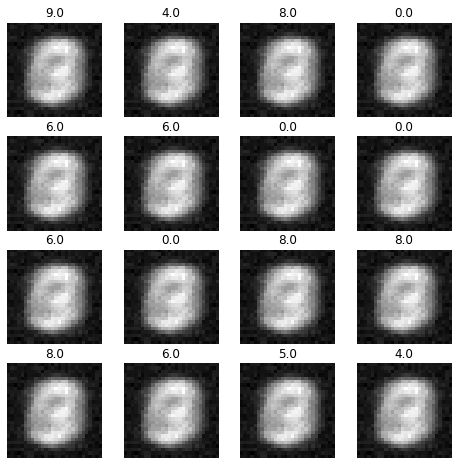

Epoch: 1 | Generator Loss: 6.10521 | Discirminator Loss: 0.48015


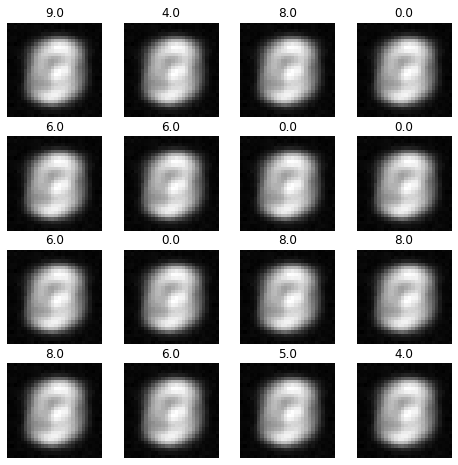

Epoch: 2 | Generator Loss: 4.13947 | Discirminator Loss: 0.69348


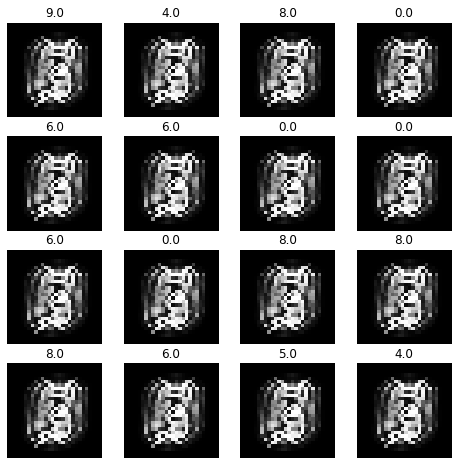

Epoch: 3 | Generator Loss: 4.03769 | Discirminator Loss: 0.71351


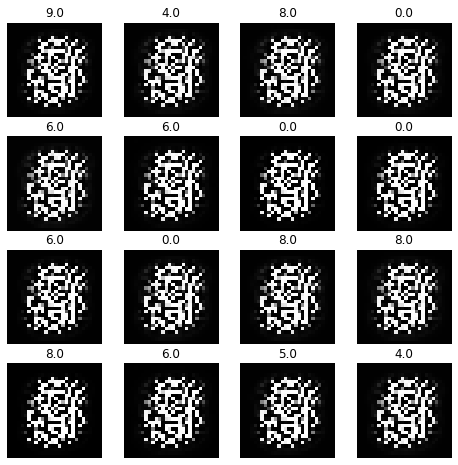

Epoch: 4 | Generator Loss: 5.57413 | Discirminator Loss: 0.47143


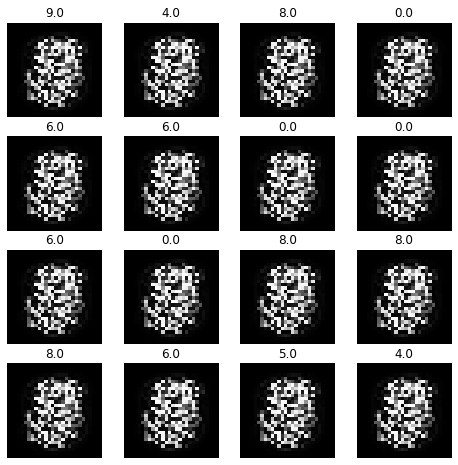

Epoch: 5 | Generator Loss: 4.33236 | Discirminator Loss: 0.49404


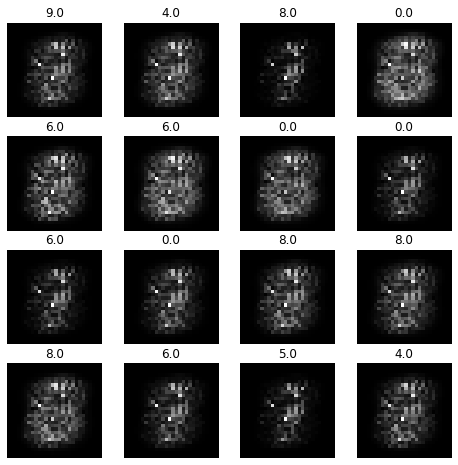

Epoch: 6 | Generator Loss: 3.85855 | Discirminator Loss: 0.48218


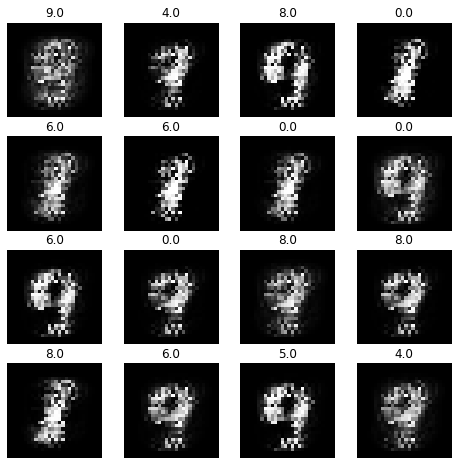

Epoch: 7 | Generator Loss: 4.47596 | Discirminator Loss: 0.43130


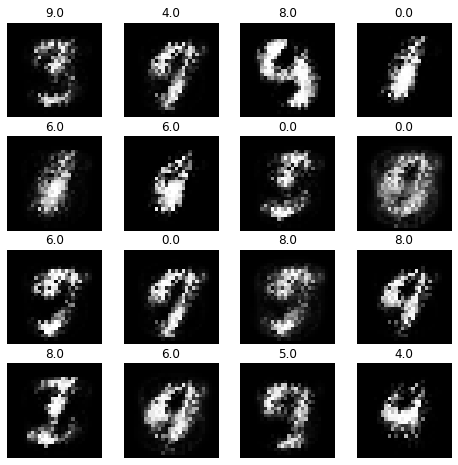

Epoch: 8 | Generator Loss: 4.19136 | Discirminator Loss: 0.45038


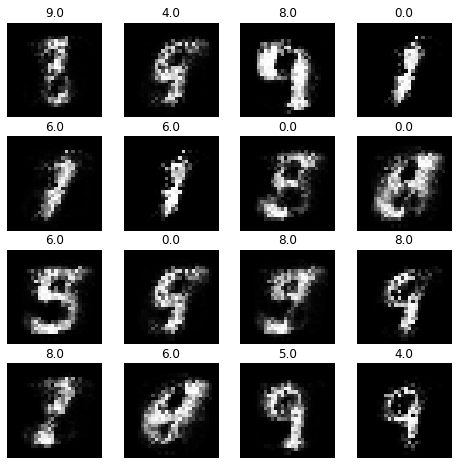

Epoch: 9 | Generator Loss: 4.32414 | Discirminator Loss: 0.48202


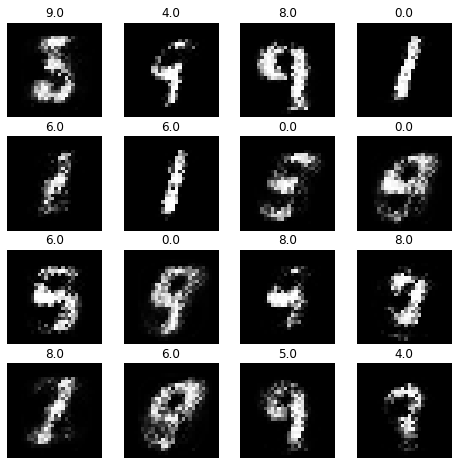

Epoch: 10 | Generator Loss: 4.31033 | Discirminator Loss: 0.53845


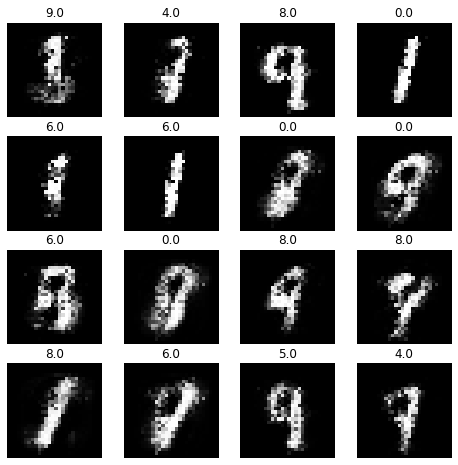

Epoch: 11 | Generator Loss: 4.20410 | Discirminator Loss: 0.59894


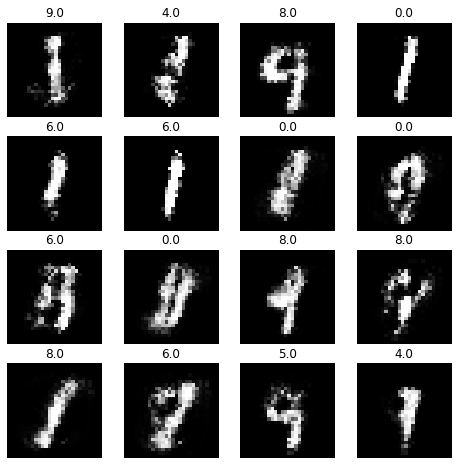

KeyboardInterrupt: 

In [9]:
epochs = 100 # a gan usually takes a lot of epochs to work properly
num_batches = 60000//batch_size
learning_rate = 0.001

Glosses = []
Dlosses = []

t = 0.0

sample_z = nd.random.normal(0, 1, (16, 100)).as_in_context(ctx)
sample_y = nd.random.randint(0, 10, (16)).as_in_context(ctx).one_hot(10)

for epoch in range(epochs):
    gcum_loss = 0.0
    dcum_loss = 0.0
    for features, labels in training_data:
        t += 1
        features = features.as_in_context(ctx)
        labels = labels.as_in_context(ctx).one_hot(10)

        # z = nd.random.normal(0, 1, (features.shape[0], 100)).as_in_context(ctx)
        
        with autograd.record():
            _, true_aux = discriminator(features)
            Dloss = cross_entropy(true_aux, labels)
            # generated = generator(z, labels)
            # false, false_aux = discriminator(generated)
            # Dloss = dloss(true, true_aux, false, false_aux, labels)
        Dloss.backward()
        adam(t, dparams, vs = dvs, sqrs = dsqrs, lr = learning_rate)

        # with autograd.record():
        #     generated = generator(z, labels)
        #     false, false_aux = discriminator(generated)
        #     Gloss = gloss(false, false_aux, labels)
        # Gloss.backward()
        # adam(t, gparams, vs = gvs, sqrs = gsqrs, lr = learning_rate)
        
        # gcum_loss += Gloss
        dcum_loss += Dloss
    
    # Gloss = gcum_loss.asscalar()/num_batches
    Dloss = dcum_loss.asscalar()/num_batches
    
    # Glosses.append(Gloss)
    Dlosses.append(Dloss)
    
    print(f'Epoch: {epoch} | Discirminator Loss: {Dloss:.5f}')
    
    generated = generator(sample_z, sample_y)
    plt.figure(figsize = (8, 8))
    for i, (image) in enumerate(generated[:16]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(image.reshape((28, 28)).asnumpy(), cmap = 'gray')
        plt.title(sample_y[i].argmax(0).asscalar())
        plt.axis('off')
    plt.show()

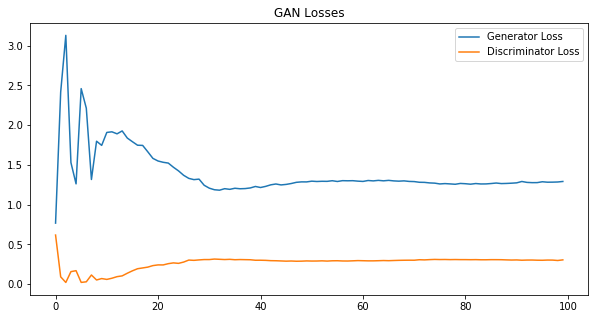

In [15]:
plt.figure(figsize = (10, 5))
plt.plot(Glosses, label = 'Generator Loss')
plt.plot(Dlosses, label = 'Discriminator Loss')
plt.legend()
plt.title('GAN Losses')
plt.show()

## Now lets generate some more data base on our desired output category
First column contain all zeros, second column all ones and so on...

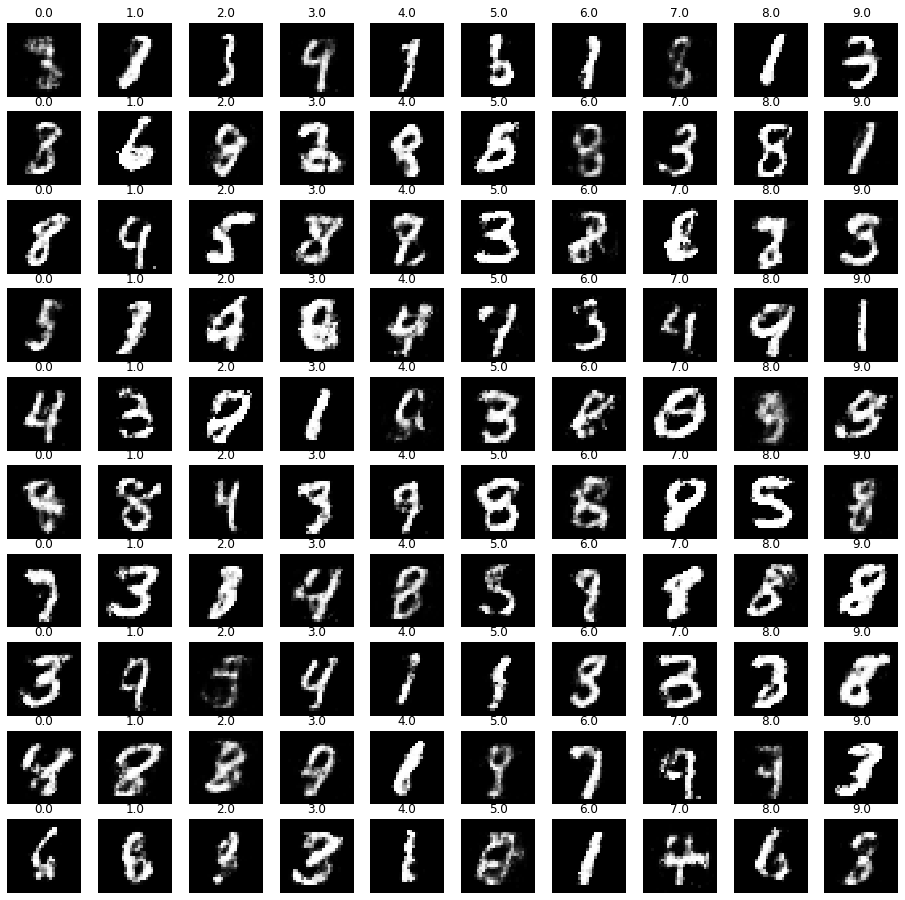

In [16]:
labels = nd.arange(0, 10, 1).tile(10).one_hot(10).as_in_context(ctx)
noise = nd.random.normal(loc = 0, scale = 1, shape = (100, 100)).as_in_context(ctx)

generated = generator(noise, labels)

plt.figure(figsize = (16, 16))
for i, (image, label) in enumerate(zip(generated, labels)):
    plt.subplot(10, 10, i + 1)
    plt.imshow(image.reshape((28, 28)).asnumpy(), 'gray')
    plt.title(label.argmax(0).asscalar())
    plt.axis('off')
plt.show()

As you can see that our generator is not properly conditioned as in conditional gan, because we are combining the discriminator with just true and false data, unlike conditional gan where we combine (concatenate) features and labels as one input.

But with more complex model architectures, AC-GAN can easily generate better and high quality images as compared go C-GAN.